## RANSAC for ground plane estimation with autonomous vehicles


Autonomous vehicles and robots are becoming more prevalent in complex transportation environments. This includes self-driving cars, personal transport modules, small versatile autonomous mobile delivery units, industrial and domestic utilitarian mobile robots, and other yet to be imagined autonomous terrain based forms.

To reliably and safely traverse their environments, each type of autonomous mobile unit needs to perceive exactly where the navigatable area is. For autonomous highway vehicles this can include roadways, drivable areas in parking lots, garages, structure interiors, and possibly off-road surfaces. An autonomous mobile robot,
on the other hand, will have a greater range of possible drivable surfaces than self-driving cars. These units need to perceive roadways, crosswalks, sidewalks, curbs, pathways, ramps, flooring, elevators, and other complex interior spaces.


Finding the best traversable areas and delimiting them into realistic paths for navigation is a multi-stage process. It begins by finding the surface plane that the mobile unit can potentially move around on. The ground plane and parameters can be derived by fitting a plane model to the best set of (x,y,z) coordinates that are closest to what would be considered to be drivable surfaces. 


These areas are first masked out using a semantic segmentation map for the image. Then only these corresponding pixel locations from the image are used to form a set of points in the 3D space of the camera frame. The plane equation model is run against this point set and optimized to the best fit. This would be the closest set of points within a preset threshold to this planar subregion of the imaged visible environment. 

In general, relatively level surface ground planes don't require an astronomically large set of points to fit a 3D plane equation. But the total number of points from image data presented to the algorithm may indeed be extremely large. There can also be large variations in data sets depending on the selection of required surfaces and the quality of visual images of the environmental scene and the accuracy of their corresponding semantic segmentations.


The RANSAC algorithm is ideal for this purpose. It can approximate the ground plane by finding an optimal set of points, from a very large sample space, that will generate the surface with the plane equation that is standard for three dimensional space: ax + by + cz + d = 0

The following algorithm is a variation of RANSAC developed for plane estimation models.


## RANSAC algorithm

RANSAC algorithm for plane estimation


       Given a set of points to fit the plane model to:

       1: Get a random sample of these points to run the model on and calculate the plane equation

       2: Find valid inliers for each point NOT in the random sample subset (this functions as a test set) by
          checking that distances to current model of the ground plane are within a preset threshold
        
       3: Check if the current number of inliers found is greater than all other previous
          inlier sets from all previous iterations
          
       4: If so then keep current inlier set as the best along with the plane parameters that generated it

       5: Check if stopping criterion is met and if so break to 7:
       
       6: Otherwise go back and continue with step 1 until max number of iterations has been reached
        
       7: Recalculate plane parameters from the best inlier batch and return it
    


## Surface plane generation with the algorithm


In [1]:
#mk
#v0.05

import numpy as np
import cv2
from matplotlib import pyplot as plt

from ransacmod import * 

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)

import sys
#print(sys.version)

import warnings
# all off
warnings.filterwarnings("ignore")
# then back  on 
#warnings.filterwarnings("default")

#np.set_printoptions(precision=2, threshold=np.nan)

### 1 - Visualize main image components


In [2]:
#create a view object

view = RoadViews()


In [4]:
# select a frame to use

view.set_frame(0) # also 1 or 2


A selected frame for a view has imaging data that are associated with it:

For example:

view.image -- the camera RGB image 

view.depth -- a depth map for the image (in meters)

view.segmentation -- an image containing the semantic segmentation map for the image 



### 1.1 - Current scene


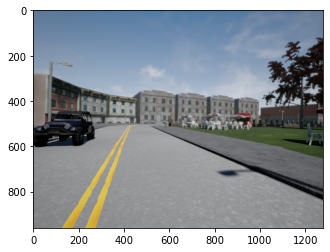

In [5]:

# take a look at the RGB image of the scene

image = view.image
plt.imshow(image)



### 1.2 - Depth map

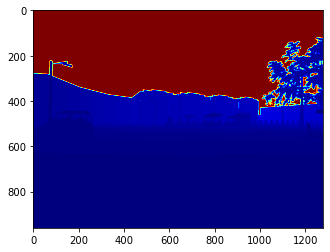

In [6]:
# take a look at the depth map

depth = view.depth
plt.imshow(depth,cmap='jet')


#plt.imshow(depth >=1000,cmap='jet') # where are outer limits 

#print(depth.shape)

### 1.3 - Semantic Segmentation

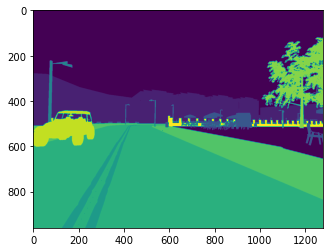

In [7]:
# semantic segmentation in raw form

segmentation = view.segmentation
plt.imshow(segmentation)


**Segmentation Category Mappings:**

The segmentation images contain mapping indices from pixel location to a road scene category.

To better visualize the semantic segmentation for categories of interest, these values are remapped to various colors. 

|Category |Mapping Index| Visualization Color|
| --- | --- | --- |
| Other| 0 | Navy Blue |
| Buildings | 1 | Red |
| Pedestrians | 4 | Teal |
| Poles | 5 | White |
| Lane Markings | 6| Purple |
| Roads | 7 | Blue |
| Side Walks| 8 | Yellow |
| Vehicles| 10 | Green |



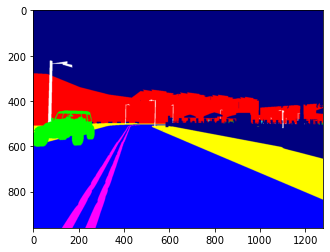

In [8]:
# the color-coded semantic segmentation map

colored_segmentation = view.visualize_segmentation(segmentation)

plt.imshow(colored_segmentation)


### 2 - Calculate 3D coordinates for all pixels in the image

The 3D coordinates are in the camera coordinate frame.

The equations to calculate the  3D coordinates are:

$$z = depth $$

$x = \frac{(u - c_u) * z}{f_x} \tag{1}$

$y = \frac{(v - c_v) * z}{f_y} \tag{2}$

$c_u$, $c_v$, and $f_x$, $f_y$ are the intrinsic calibration parameters found in the camera calibration matrix K:

$$K = \begin{pmatrix} f_x & 0 & c_u \\ 0 & f_y & c_v \\ 0& 0 & 1 \end{pmatrix}$$

***Note***: fx and fy are often the same but not always so specify



In [9]:
# get (x,y,z) coords 

x,y = view.xy_from_depth(depth)
z=depth


### 3 - RANSAC algorithm implementation


The defaults are for a very minimal case. Parameters are available to fine tune the RANSAC algorithm for a best result balanced with runtime requirements.

If the algoritm runs to exhaustion, it bails out at a fixed maximum number of iterations

Runtime readouts are provided


In [10]:
def ransac_plane_fit(points, fixed_num_samples=None, min_num_inliers=None, \
                     max_iterations=None, verbose=True):
    """
    v0.18
    
    allows choice of parameters:
        minimun required inliers
        fixed  number of samples to fit model on
        max number of iterations
        verbose mode can be set to show progress & stats of run
        
    Computes plane coefficients a,b,c,d of the plane in the form ax+by+cz+d = 0
    using RANSAC algorithm for outlier rejection

    Arguments:
    points --  (3, N), contains all data points for random sampling 

    Returns:
    output_plane --  (1, 4) vector of the plane equation parameters a,b,c,d 
    """
    
    if verbose==True:
        print()
        print("RANSAC: START")
        print("calculating...",end=' ')
          
    # runtime parameters
    
    #default
    if (max_iterations==None):
        max_iterations = 3  # RANSAC maximum number of iterations
    if (max_iterations <=0): max_iterations=3
        
    #sample_percent = 0.000
        
    #fixed_num_inliers = 0 # if 0 => use percent
  
    
    if (fixed_num_samples==None or fixed_num_samples <= 0):
         num_samples = 15 # if 0 => use percent
        #num_samples = int(sample_percent*points.shape[1])
    else:

        num_samples=fixed_num_samples #from function call

    
    min_inliers_percent = 0.50 
    
    if (min_num_inliers == None):
        min_req_inliers = int(min_inliers_percent*points.shape[1]) # RANSAC minimum number of inliers
    else:
        min_req_inliers = np.abs(min_num_inliers)
    
    
    distance_threshold = 0.01 # Maximum distance from point to plane for point to be considered inlier
   
    # the sample space is basically a training set for the model
    # and the non-sample points are the test set; keep them partitioned
    
    # num_samples=int(0.001*points.shape[1]) # take a percentage
    
    # INIT
    current_max_inliers = 0
    best_inlier_set = []
    
    # out of curiosity
    # road percentage of total image pixels
    road_point_percent=points.shape[1]/(image.shape[0]*image.shape[1])

    for i in range(max_iterations):
        
        if verbose==True:
            print('*',end=' ') #progress indicator
          
        # 1: 
        # get a random sample of points to run model on

        # random index into points
        index = np.random.choice(points.shape[1], num_samples, replace=False)
       
        samples = points[:,index]
        
        # 2: 
        # calculate plane model
        plane=calc_plane(samples)
        
        # 3: 
        # find valid inliers
        # for each point NOT in random sample subset (ie this is a test set)
        # check distances to ground plane against threshold
   
        inliers = []
        
        for p in range(points.shape[1]):
            # test with points not in samples
            if (p not in index):
                x,y,z = points[:,p]
                # save ok point to inliers
                if distance_to_plane(plane,x,y,z) < distance_threshold:
                    inliers.append(points[:,p])
                    
        # 4: 
        # Check if the current number of inliers is greater than all previous
        # iterations and keep the best inlier set with the largest number of points

        # keep the best plane fit parameters so far
        # and best inlier set
        
        if len(inliers) > current_max_inliers:
            
            current_max_inliers = len(inliers)
            current_best_plane=plane
            best_inlier_set = inliers
        
        # 5: # EXIT CONDITION
        # Check if stopping criterion is met and break 
        
        if current_max_inliers > min_req_inliers:
            break
              
    # break out of or fell through iteration loop here


    # recompute plane parameters from 
    # the best inlier batch & return it
        
    output_plane=calc_plane(np.array(best_inlier_set).T)
    #out=output_plane
    if verbose==True:
        print()
        print("RANSAC: END");print()
        print("# of iterations run: "+str(i+1))
        print("# fixed samples: "+ str(fixed_num_samples))
        print("min % inliers required: "\
              +str( round((min_req_inliers/points.shape[1]) *100))+str(" %"))
        
        if (fixed_num_samples == 0):
            print("# percentage samples: "+ str(sample_percent))
            
        print("actual # samples used: "+str(num_samples))
        print("max # inliers found: "+str(len(best_inlier_set)))
        percent = int((len(best_inlier_set)/points.shape[1])*100)
        print("inliers % of points processed: "+str(percent)+" %")
        
        print()
    
    return output_plane 


### 4 - Create a segmentation mask for the road surfaces

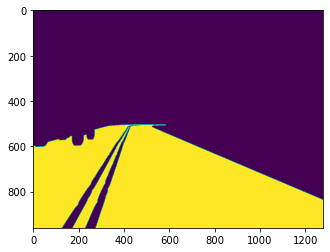

In [11]:
# create pixel mask for road surfaces 

road_mask = np.zeros(segmentation.shape)
road_mask[segmentation == 7] = 1 # 7 is road surfaces

# take a look to check road mask
plt.imshow(road_mask)

# Get (x,y,z) coordinates of pixels in road mask
x_ground = x[road_mask == 1]
y_ground = y[road_mask == 1]
z_ground = view.depth[road_mask == 1]

xyz_ground = np.stack((x_ground, y_ground, z_ground))


### 5 - Run  RANSAC 

In [12]:
# run ransac 
# 



min_inliers=int(0.80*xyz_ground.shape[1]) # use this percentage of sample space

#p_final = ransac_plane_fit(xyz_ground) #easy to set up minimal case 
#p_final = ransac_plane_fit(xyz_ground, fixed_num_samples=8) #r this          
p_final = ransac_plane_fit(xyz_ground, fixed_num_samples=25, min_num_inliers=min_inliers)
#p_final = ransac_plane_fit(xyz_ground, fixed_num_samples=None, min_num_inliers=min_inliers)
#p_final = ransac_plane_fit(xyz_ground, fixed_num_samples=25)#

                      
######
print('Ground Plane equation cooeficients [a,b,c,d]: ' + str(p_final))
print()
print("If the drivable region is a relatively level surface expect to see something close to:")
print();print("[0, -1, 0, +d] or [0, 1, 0, -d]");print() 


#print("Note: the positive (+) y-axis direction is below the camera center ")
#print("where the road needs to be!")



RANSAC: START
calculating... * 
RANSAC: END

# of iterations run: 1
# fixed samples: 25
min % inliers required: 80 %
actual # samples used: 25
max # inliers found: 411168
inliers % of points processed: 99 %

Ground Plane equation cooeficients [a,b,c,d]: [ 0.01791606 -0.99981332  0.00723434  1.40281478]

If the drivable region is a relatively level surface expect to see something close to:

[0, -1, 0, +d] or [0, 1, 0, -d]



### 6 - Visualize the drivable surfaces 

Verify the estimated plane is by visualizing the surfaces generated
by the the plane equation calculated on the best inlier set found by RANSAC.

These are all surfaces that are co-planar the road surface 
indicated in the semantic segmenation map of the scene

So not all of them may be usable as drivable surfaces to navigate on!


### 6.1 -  Camera  Point Of View (POV)

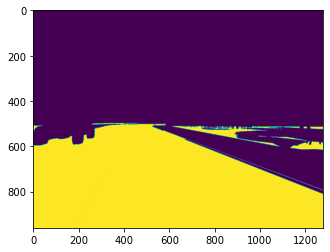

In [13]:

dist = np.abs(distance_to_plane(p_final, x, y, z))

ground_mask = np.zeros(dist.shape)

ground_mask[dist < 0.1] = 1
ground_mask[dist > 0.1] = 0


#plt.imshow(road_mask)

plt.imshow(ground_mask)

### 6.2 - 3D Birds-Eye View Of The Surfaces 

Visualize the estimated navigatable space.

Top-down 3D view of the surfaces generated by the plane equation



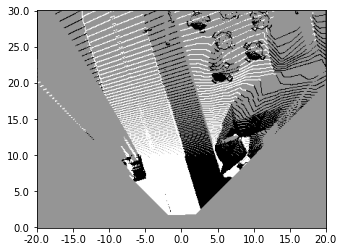

In [14]:

view.show_overhead_view(ground_mask)
